# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import math
import tensorflow as tf
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation
import h5py
from keras.optimizers import Adamax, Nadam
import sys
import pickle

from interval import interval, inf

In [5]:
sys.path.append('/Users/nishant/Dropbox (University of Michigan)/research/verified-ml/SafeVerticalCAS/GenerateNetworks')

In [6]:
from utils.safe_train import *


# Constants

In [10]:
######## OPTIONS #########
ver = 4  # Neural network version
hu = 45  # Number of hidden units in each hidden layer in network
totalEpochs = 2  # Total number of training epochs
BATCH_SIZE = 2**9
EPOCH_TO_PROJECT = 1
trainingDataFiles = (
    "../../TrainingData/VertCAS_TrainingData_v2_%02d.h5"  # File format for training data
)
nnetFiles = "../../networks/ProjectionVertCAS_pra%02d_v%d_45HU_%03d.nnet"  # File format for .nnet files
COC_INTERVAL = [
    interval[-1000, -900],
    interval[50, 52],
    interval[-1, 1],
    interval[20, 22],
]
DES_INTERVAL = [
    interval[100, 110],
    interval[0, 0.5],
    interval[0, 0.5],
    interval[20, 21],
]

# COC high, SDES2500 low
desired_interval = [
    interval[7000, 15000],  # COC
    None,  # DNC
    None,  # DND
    None,  # DES1500
    None,  # CL1500
    None,  # SDES1500
    None,  # SCL1500
    interval[-2000, 6000],  # SDES2500
    None,  # SCL2500
]
# TODO make this dynamically set
INTERVAL_WIDTH = 2
advisories = {
    "COC": 0,
    "DNC": 1,
    "DND": 2,
    "DES1500": 3,
    "CL1500": 4,
    "SDES1500": 5,
    "SCL1500": 6,
    "SDES2500": 7,
    "SCL2500": 8,
}
##########################

In [11]:
pra = 1

# ADVISORY INDICES
COC=0
DNC=1
DND=2
DES1500 = 3
CL1500 = 4
SDES1500=5
SCL1500=6
SDES2500=7
SCL2500=8

advisories = {
    "COC": 0,
    "DNC": 1,
    "DND": 2,
    "DES1500": 3,
    "CL1500": 4,
    "SDES1500": 5,
    "SCL1500": 6,
    "SDES2500": 7,
    "SCL2500": 8,
}

In [12]:
print("Loading Data for VertCAS, pra %02d, Network Version %d" % (pra, ver))
f = h5py.File(trainingDataFiles % pra, "r")
X_train = np.array(f["X"])
Q = np.array(f["y"])
means = np.array(f["means"])
ranges = np.array(f["ranges"])
min_inputs = np.array(f["min_inputs"])
max_inputs = np.array(f["max_inputs"])
print(f"min inputs: {min_inputs}")
print(f"max inputs: {max_inputs}")

N, numOut = Q.shape
print(f"Setting up model with {numOut} outputs and {N} training examples")
num_batches = N / BATCH_SIZE

Loading Data for VertCAS, pra 01, Network Version 4
min inputs: [-8000.  -100.  -100.     0.]
max inputs: [8000.  100.  100.   40.]
Setting up model with 9 outputs and 4053465 training examples


# Train

In [13]:
desired_interval = [
    None,  # COC
    None,  # DNC
    None,  # DND
    interval[1, 10],  # DES1500
    None,  # CL1500
    None,  # SDES1500
    None,  # SCL1500
    None,  # SDES2500
    None,  # SCL2500
]

In [14]:
# Asymmetric loss function
lossFactor = 40.0

# NOTE(nskh): from HorizontalCAS which was updated to use TF
def asymMSE(y_true, y_pred):
    d = y_true - y_pred
    maxes = tf.argmax(y_true, axis=1)
    maxes_onehot = tf.one_hot(maxes, numOut)
    others_onehot = maxes_onehot - 1
    d_opt = d * maxes_onehot
    d_sub = d * others_onehot
    a = lossFactor * (numOut - 1) * (tf.square(d_opt) + tf.abs(d_opt))
    b = tf.square(d_opt)
    c = lossFactor * (tf.square(d_sub) + tf.abs(d_sub))
    d = tf.square(d_sub)
    loss = tf.where(d_sub > 0, c, d) + tf.where(d_opt > 0, a, b)
    return tf.reduce_mean(loss)

# Define model architecture
model = Sequential()
model.add(Dense(hu, activation="relu", input_dim=4))
model.add(Dense(hu, activation="relu"))
model.add(Dense(hu, activation="relu"))
model.add(Dense(hu, activation="relu"))
model.add(Dense(hu, activation="relu"))
model.add(Dense(hu, activation="relu"))

# model.add(Dense(numOut, init="uniform"))
model.add(Dense(numOut))
opt = Nadam(learning_rate=0.0003)
model.compile(loss=asymMSE, optimizer=opt, metrics=["accuracy"])

Metal device set to: Apple M1 Pro


2023-08-08 12:31:21.841197: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-08 12:31:21.841605: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


on epoch 0
 25/304 [=>............................] - ETA: 0s 006 and accuracy 0.9167900085449219

2023-08-08 12:36:35.069159: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-08-08 12:36:35.133559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


304/304 [==============================] - 1s 2ms/step


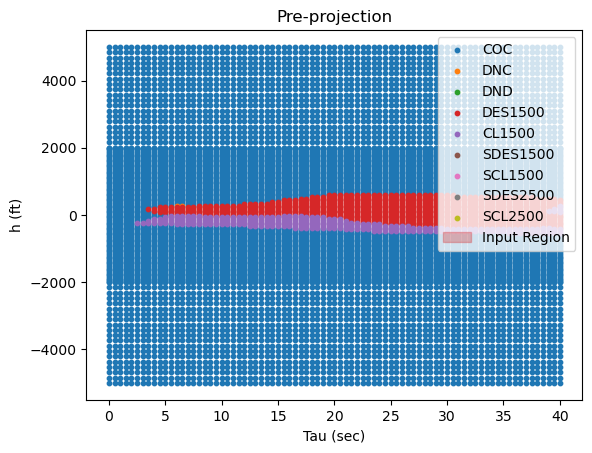

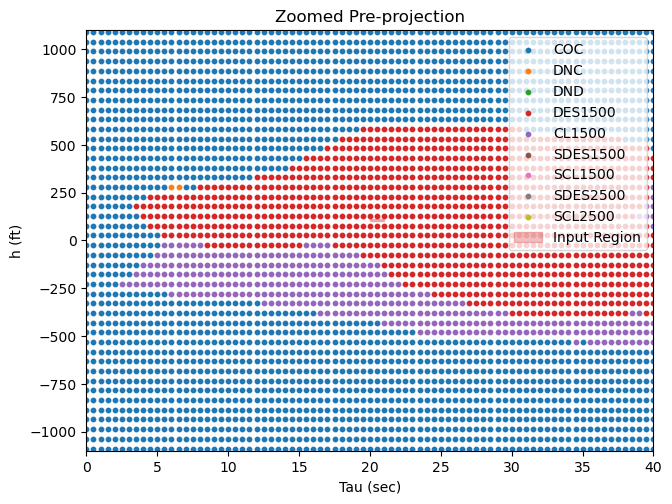

safe region test FAILED, interval was [interval([-11.559544278173476, 9.249029137825534]), interval([-16.38818927047695, 9.37519020026806]), interval([-16.054337727878735, 10.329363672190773]), interval([-12.389039422369336, 13.187096362485955]), interval([-13.1752363131888, 18.068495329394864]), interval([-15.271079260494085, 7.864124036792093]), interval([-12.656802075879492, 8.520392586381346]), interval([-13.935622275628662, 11.393979550963587]), interval([-12.754257471319775, 8.247333967128368])]

Projecting weights at epoch 0.
After projecting, output interval is [interval([-11.559544278173476, 9.249029137825534]), interval([-16.38818927047695, 9.37519020026806]), interval([-16.054337727878735, 10.329363672190773]), interval([-inf, inf]), interval([-13.1752363131888, 18.068495329394864]), interval([-15.271079260494085, 7.864124036792093]), interval([-12.656802075879492, 8.520392586381346]), interval([-13.935622275628662, 11.393979550963587]), interval([-12.754257471319775, 8.2473

/Users/nishant/miniforge3/envs/mlp/lib/python3.10/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


304/304 [==============================] - 1s 2ms/step


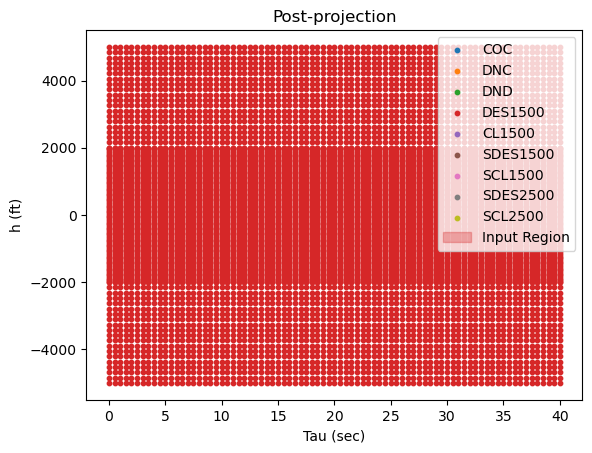

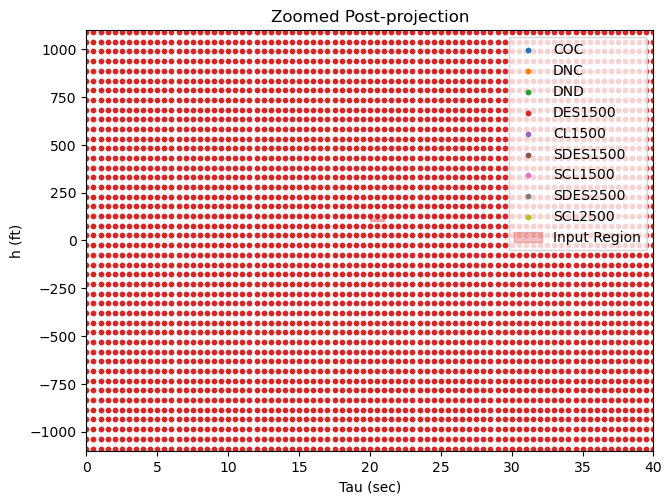

In [15]:
epoch_losses = []
epoch_accuracies = []
weights_before_projection = []
weights_after_projection = []
for epoch in range(1):
    # if epoch % 5 == 0:
    print(f"on epoch {epoch}")

    rng = np.random.default_rng()

    train_indices = np.arange(X_train.shape[0])

    rng.shuffle(train_indices)  # in-place

    x_shuffled = X_train[train_indices, :]
    y_shuffled = Q[train_indices, :]

    x_batched = np.split(
        x_shuffled, np.arange(BATCH_SIZE, len(x_shuffled), BATCH_SIZE)
    )
    y_batched = np.split(
        y_shuffled, np.arange(BATCH_SIZE, len(y_shuffled), BATCH_SIZE)
    )

    dataset_batched = list(zip(x_batched, y_batched))
    batch_losses = []
    batch_accuracy_list = []
    epoch_accuracy = keras.metrics.CategoricalAccuracy()
    for step, (x_batch_train, y_batch_train) in enumerate(dataset_batched):
        with tf.GradientTape() as tape:
            y_pred = model(x_batch_train, training=True)  # Forward pass
            loss = asymMSE(y_batch_train, y_pred)
            epoch_accuracy.update_state(y_batch_train, y_pred)

            # accumulate data
            batch_losses.append(loss.numpy())
            batch_accuracy_list.append(epoch_accuracy.result())
        if step % int(num_batches / 500) == 0:
            print(
                f"{np.round(step / num_batches * 100, 1)}% through this epoch with loss",
                f"{np.round(loss.numpy(), 5)} and accuracy {np.round(epoch_accuracy.result(), 5)}\r",
                end="",
            )
        # Compute gradients
        trainable_vars = model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        opt.apply_gradients(zip(gradients, trainable_vars))

    epoch_accuracies.append(batch_accuracy_list)
    epoch_losses.append(batch_losses)

    weights_before_projection.append([w.numpy() for w in model.layers[-1].weights])
    plot_policy(model, savefig=False, filename=f"images/fomlas-epoch{epoch}-pre-projection.pdf", 
                zoom=True, intervals=DES_INTERVAL, intervalcolor="C3", title="Pre-projection")   
    model.save("models/aug-08-standard-model-epoch-01.keras")

    # Parameters:
    # - h (ft): Altitude of intruder relative to ownship, [-8000, 8000]
    # - vO (ft/s): ownship vertical climb rate, [-100, 100]
    # - vI (ft/s): intruder vertical climb rate, [-100, 100]
    # - τ (sec): time to loss of horizontal separation
    output_interval, penultimate_interval = propagate_interval(
        normalize_interval(
            DES_INTERVAL
        ),  # MAKE SURE to normalize interval for reasonable results
        model,
        graph=False,
    )
    if not check_max_score(output_interval, advisories["DES1500"]):
        print(f"safe region test FAILED, interval was {output_interval}")
        if epoch % EPOCH_TO_PROJECT == 0:
            print(f"\nProjecting weights at epoch {epoch}.")
            intervals_to_project = []
            # go through all intervals, find max upper bound
            max_upper_bound = None
            for i, advisory_interval in enumerate(output_interval):
                if i == advisories["DES1500"]:
                    continue
                else:
                    if max_upper_bound is None:
                        max_upper_bound = advisory_interval[0].sup
                    else:
                        max_upper_bound = max(
                            advisory_interval[0].sup, max_upper_bound
                        )

            intervals_to_project = [advisories["DES1500"]]

            weights_tf = model.layers[-1].weights
            weights_np = weights_tf[0].numpy()
            biases_np = weights_tf[1].numpy()

            for idx in intervals_to_project:
                # weights_to_project = np.hstack([weights_np[:, idx], biases_np[idx]])
                weights_to_project = weights_np[:, idx]
                proj = project_weights(
                    interval[max_upper_bound, max_upper_bound + INTERVAL_WIDTH],
                    penultimate_interval,
                    weights_to_project,
                )
                weights_np[:, idx] = proj
                # weights_np[:, idx] = proj[:-1]
                # biases_np[idx] = proj[-1]

            model.layers[-1].set_weights([weights_np, biases_np])
            output_interval, _ = propagate_interval(
                normalize_interval(DES_INTERVAL),
                model,
                graph=False,
            )
            print(f"After projecting, output interval is {output_interval}")
            weights_after_projection.append(
                [w.numpy() for w in model.layers[-1].weights]
            )
            model.save("models/aug-08-post-projection-model-epoch-01.keras")
#     if not check_intervals(output_interval, desired_interval):
#         print(f"safe region test FAILED, interval was {output_interval}")
#         if epoch % EPOCH_TO_PROJECT == 0:
#             print(f"\nProjecting weights at epoch {epoch}.")
#             intervals_to_project = []
#             assert type(output_interval) == type(desired_interval)
#             if type(output_interval) is list:
#                 assert len(output_interval) == len(desired_interval)
#                 for i in range(len(output_interval)):
#                     if (
#                         desired_interval[i] is not None
#                         and output_interval[i] not in desired_interval[i]
#                     ):
#                         intervals_to_project.append(i)
#             else:
#                 intervals_to_project.append(0)

#             weights_tf = model.layers[-1].weights
#             weights_np = weights_tf[0].numpy()
#             biases_np = weights_tf[1].numpy()

#             for idx in intervals_to_project:
#                 weights_to_project = np.hstack([weights_np[:, idx], biases_np[idx]])
#                 proj = project_weights(
#                     desired_interval[idx], penultimate_interval, weights_to_project
#                 )
#                 weights_np[:, idx] = proj[:-1]
#                 biases_np[idx] = proj[-1]

#             model.layers[-1].set_weights([weights_np, biases_np])
#             output_interval, _ = propagate_interval(
#                 COC_INTERVAL,
#                 model,
#                 graph=False,
#             )
#             print(f"After projecting, output interval is {output_interval}")
#             weights_after_projection.append(
#                 [w.numpy() for w in model.layers[-1].weights]
#             )

    else:
        print(f"safe region test passed, interval was {output_interval}")

    # Logging outputs
    with open("projection_acas_aug08_coc.pickle", "wb") as f:
        data = {
            "accuracies": epoch_accuracies,
            "losses": epoch_losses,
            "weights_before_projection": weights_before_projection,
            "weights_after_projection": weights_after_projection,
        }
        pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
        
    plot_policy(model, savefig=False, filename=f"images/fomlas-epoch{epoch}-post-projection.pdf", 
                zoom=True, intervals=DES_INTERVAL, intervalcolor="C3", title="Post-projection")

In [14]:
penultimate_interval

[interval([0.0, inf]),
 interval([0.0, inf]),
 interval([0.0, inf]),
 interval([0.0, inf]),
 interval([0.0, inf]),
 interval([0.0, inf]),
 interval([0.0, inf]),
 interval([0.0, inf]),
 interval([0.0, inf]),
 interval([0.0, inf]),
 interval([0.0, inf]),
 interval([0.0, inf]),
 interval([0.0, inf]),
 interval([0.0, inf]),
 interval([0.0, inf]),
 interval([0.0, inf]),
 interval([0.0, inf]),
 interval([0.0, inf]),
 interval([0.0, inf]),
 interval([0.0, inf]),
 interval([0.0, inf]),
 interval([0.0, inf]),
 interval([0.0, inf]),
 interval([0.0, inf]),
 interval([0.0, inf]),
 interval([0.0, inf]),
 interval([0.0, inf]),
 interval([0.0, inf]),
 interval([0.0, inf]),
 interval([0.0, inf]),
 interval([0.0, inf]),
 interval([0.0, inf]),
 interval([0.0, inf]),
 interval([0.0, inf]),
 interval([0.0, inf]),
 interval([0.0, inf]),
 interval([0.0, inf]),
 interval([0.0, inf]),
 interval([0.0, inf]),
 interval([0.0, inf]),
 interval([0.0, inf]),
 interval([0.0, inf]),
 interval([0.0, inf]),
 interval([

In [11]:
import matplotlib.pyplot as plt

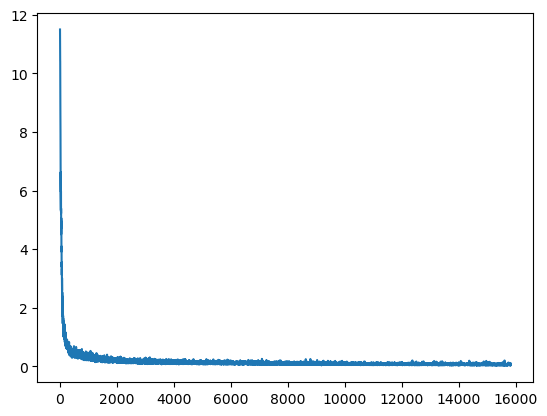

In [12]:
plt.figure()
plt.plot(batch_losses)
plt.show()

In [13]:
advisories

{'COC': 0,
 'DNC': 1,
 'DND': 2,
 'DES1500': 3,
 'CL1500': 4,
 'SDES1500': 5,
 'SCL1500': 6,
 'SDES2500': 7,
 'SCL2500': 8}

In [76]:
# COC high, SDES2500 low
desired_interval = [interval[7000, 15000],  # COC
                    None,           # DNC
                    None,           # DND
                    None,           # DES1500
                    None,           # CL1500
                    None,           # SDES1500
                    None,           # SCL1500
                    interval[-2000, 6000],  # SDES2500
                    None,           # SCL2500
                   ]

In [13]:
def check_intervals(output_interval, goal_interval):
    assert type(output_interval) == type(goal_interval)
    if type(output_interval) is list:
        assert len(output_interval) == len(goal_interval)
        for i in range(len(output_interval)):
            if goal_interval[i] is not None and output_interval[i] not in goal_interval[i]:
                return False
        return True
    else:
        return output_interval in goal_interval

In [14]:
output_interval

[interval([-2260.4474587077575, 6254.7313829800505]),
 interval([-6016.414571449502, 6390.889435382497]),
 interval([-9953.235220686383, 6650.544893240611]),
 interval([-7094.378883646252, 4794.872261623323]),
 interval([-12704.856161526073, 6596.152293679708]),
 interval([-5798.244003059197, 2880.27408345843]),
 interval([-9798.605758997091, 1318.8253900765633]),
 interval([-6407.489985129032, 4301.543306242515]),
 interval([-9265.462345058428, 1938.5843370979335])]

In [15]:
desired_interval

[[7000, 15000], None, None, None, None, None, None, [-2000, 6000], None]

In [16]:
check_intervals(output_interval, desired_interval)

False

In [18]:
# passes for all None, as expected
check_intervals(output_interval, [None] * len(output_interval)) 

True

## Multi-output Projection Approach

- copy the existing weights into a matrix to modify as projection occurs
- copy the existing biases into vector to modify as projection occures
- for each goal interval that is 1) specified and 2) violated
  - extract the weights corresponding to that interval (row index), like `weights[:, COC]`
  - add the bias term (single scalar after indexing `biases[COC]`)
  - project **only** those weights
  - write projected weights (all but last elements—shapes will work out) in the copied weight matrix
  - write projected bias (last element, is scalar) in the copied bias vector
- write the new projected weights/biases to the layer

In [22]:
if not check_intervals(output_interval, desired_interval):
    print(f"safe region test FAILED, interval was {output_interval}")

safe region test FAILED, interval was [interval([-5584.508180793874, 7994.710975043832]), interval([-7902.970751832629, 5613.479000542001]), interval([-11146.146172941055, 9002.217790166424]), interval([-9510.611064770206, 7458.622574573421]), interval([-11563.672071942157, 6270.477143083172]), interval([-6596.104813362566, 6522.46237709049]), interval([-11858.945758035074, 5426.811983882955]), interval([-6846.167681722877, 7358.995740508499]), interval([-9959.762061751766, 4454.861052006466])]


In [23]:
if epoch % EPOCH_TO_PROJECT == 0:
    print(f"\nProjecting weights at epoch {epoch}.")
    weights = model.layers[-1].weights
    
    intervals_to_project = []
    assert type(output_interval) == type(desired_interval)
    if type(output_interval) is list:
        assert len(output_interval) == len(desired_interval)
        for i in range(len(output_interval)):
            if desired_interval[i] is not None and output_interval[i] not in desired_interval[i]:
                intervals_to_project.append(i)
    else:
        intervals_to_project.append(0)


Projecting weights at epoch 0.


In [24]:
intervals_to_project

[0, 7]

In [41]:
weights_tf = model.layers[-1].weights
weights_tf

[<tf.Variable 'dense_13/kernel:0' shape=(45, 9) dtype=float32, numpy=
 array([[ 0.03942439,  0.33321533,  0.4482844 ,  0.21958579,  0.9443816 ,
          0.3140624 ,  0.25886098,  0.09848318,  0.40925547],
        [-0.6124311 ,  0.26229328,  0.2642309 ,  0.10484258,  0.12010924,
         -0.1739827 ,  0.20271666,  0.07693958, -0.11393648],
        [-0.18324462, -0.39377138,  0.2667933 ,  0.250268  ,  0.35068864,
          0.10769755, -0.23915434,  0.27487418, -0.05766522],
        [ 0.37017465, -0.14836311, -0.04202354,  0.10501212, -0.10738994,
         -0.16520362, -0.14229111,  0.00308613,  0.188874  ],
        [-0.06335454, -0.4276046 ,  0.23788382, -0.45187384, -0.3388332 ,
         -0.32573277, -0.30852467, -0.16509883,  0.02480486],
        [-0.3488834 , -0.00445438, -0.21839443,  0.2414549 , -0.26131445,
         -0.03585581, -0.34045488,  0.03856819, -0.01146971],
        [ 0.3392895 , -0.31380722, -0.13589667, -0.08578171,  0.00874358,
         -0.25384882,  0.27856746, -0.00

In [42]:
weights_np = weights[0].numpy()
biases_np = weights[1].numpy()

In [43]:
# penultimate_interval

### Long approach

In [44]:
for idx in intervals_to_project:
    weights_to_project = np.hstack([weights_np[:, idx], biases_np[idx]])
    print(weights_to_project)
    print(weights_to_project.shape)
    lowers = []
    uppers = []
    for i, ivl in enumerate(penultimate_interval):
        if weights_to_project[i] < 0:
            # swap order if negative
            lowers.append(ivl[0][1])
            uppers.append(ivl[0][0])
        else:
            lowers.append(ivl[0][0])
            uppers.append(ivl[0][1])

    interval_combinations = [lowers, uppers]
    constraint_vectors = [np.hstack([elem, 1]) for elem in interval_combinations]
    x = cp.Variable(weights_to_project.shape)
    constraints = []
    for constraint_vector in constraint_vectors:
        constraints.append(constraint_vector @ x >= desired_interval[0][0])
        constraints.append(constraint_vector @ x <= desired_interval[0][1])

    for i in range(len(weights_to_project)-1):
        constraint_row = np.zeros(weights_to_project.shape)
        np.put(constraint_row,i,1)
        if weights_to_project[i] >= 0:
            # enforce weight stays positive
            constraints.append(constraint_row @ x >= 0)
        else:
            # enforce weight stays negative
            constraints.append(constraint_row @ x <= 0)    

    obj = cp.Minimize(cp.norm(x - weights_to_project))
    prob = cp.Problem(obj, constraints)
    t1 = time.time()
    prob.solve()  # Returns the optimal value.
    print(f"solving took {time.time() - t1} seconds")
    print(f"optimization status: {prob.status}")
    proj = x.value
    # signs_proj = ["+" if weight >= 0 else "-" for weight in proj]
    # print(proj)
    # print(signs_proj)
    # print(coc_weights)
    # print(signs_orig)

    proj_out = 0
    for i, weight in enumerate(proj[:-1]):
        proj_out += penultimate_interval[i] * weight
    proj_out += proj[-1]
    print(f"interval after projection was {proj_out}")

    # sign_change_indices = []
    # for i in range(len(signs_proj)):
    #     if signs_proj[i] != signs_orig[i]:
    #         sign_change_indices.append(i)
    # print(f"{len(sign_change_indices)} indices changed sign during projection: {sign_change_indices}")

    # print(f"weights that flipped were originally {coc_weights[sign_change_indices]}")

[ 0.03942439 -0.6124311  -0.18324462  0.37017465 -0.06335454 -0.3488834
  0.3392895   0.1650918   0.3710678  -0.00829957 -0.1246558  -0.308134
  0.07442454  0.03110414 -0.33364585 -0.34130403  0.07751751 -0.06251903
  0.14351563 -0.10729069  0.07971735  0.11098543 -0.40912476  0.11649306
 -0.16919449  0.09237438 -0.13308978 -0.17952855  0.04569219 -0.10015909
 -0.13179371 -0.01709867 -0.01063925 -0.32481274  0.18692982 -0.14854527
 -0.08550899  0.04151714  0.28354126 -0.12024345 -0.09336283 -0.14308341
 -0.07447216  0.11878908  0.22825216  0.01702375]
(46,)
solving took 0.017178773880004883 seconds
optimization status: optimal
interval after projection was interval([7000.000000251744, 14999.999999651764])
[ 0.09848318  0.07693958  0.27487418  0.00308613 -0.16509883  0.03856819
 -0.00850692  0.17529978  0.20034891  0.19163598  0.31327233  0.4515588
 -0.1245755  -0.03022388  0.09295411 -0.0315096  -0.21070488 -0.25765285
  0.47021732 -0.05160411  0.05052869  0.19602552  0.18728337  0.195

### With function

In [113]:
for idx in intervals_to_project:
    weights_to_project = np.hstack([weights_np[:, idx], biases_np[idx]])
    proj = project_weights(desired_interval[idx], 
                           penultimate_interval, 
                           weights_to_project)

    proj_out = 0
    for i, weight in enumerate(proj[:-1]):
        proj_out += penultimate_interval[i] * weight
    proj_out += proj[-1]
    print(f"interval after projection was {proj_out}")
    weights_np[:, idx] = proj[:-1]
    biases_np[idx] = proj[-1]

interval after projection was interval([7000.000000012397, 14999.999999948317])
interval after projection was interval([-1999.9999998197545, 5999.999999823131])


In [104]:
proj[-1]

-0.07289923727510303

In [102]:
biases_np

array([ 0.01702375, -0.01381799,  0.00414154,  0.05387181,  0.0431052 ,
       -0.11384217, -0.0549253 , -0.07289924, -0.07280885], dtype=float32)

In [108]:
biases_np - np.array([ 0.01702375, -0.01381799,  0.00414154,  0.05387181,  0.0431052 ,
        -0.11384217, -0.0549253 , -0.07289924, -0.07280885])

array([-3.50475312e-10,  4.45788145e-09,  1.19789600e-09,  4.36248780e-10,
        3.65834236e-09,  3.03976060e-09, -1.80912015e-10,  2.72487641e-09,
        3.16867828e-09])

In [ ]:
# if epoch % EPOCH_TO_PROJECT == 0:
#     print(f"\nProjecting weights at epoch {epoch}.")
#     weights = model.layers[-1].weights
#     print(
#         f"Old weights: {np.squeeze(np.array([weight.numpy() for weight in weights]))}"
#     )
#     projected_weights = project_weights(
#         desired_interval,
#         penultimate_interval,
#         np.squeeze(np.array(weights)),
#     )
#     print(
#         f"Projected weights: {projected_weights} yield new interval: "
#         f"{penultimate_interval * projected_weights[0] + projected_weights[1]}"
#     )
#     proj_weight, proj_bias = projected_weights
#     model.layers[-1].set_weights(
#         [np.array([[proj_weight]]), np.array([proj_bias])]
#     )
#     # NOTE: assume positive weights
#     # TODO: handle both signs of weights

#     # print(optimizer.get_weights())
#     # optimizer.set_weights(last_safe_weights)
# else:
#     print(f"safe region test passed, interval was {output_interval}")

# Testing sign-aware projection

Without this, there's exponential behavior in ordering the interval upper/lower bounds when generating constraints, which leads to overflow and crashes.

In [9]:
output_interval = [interval([-2260.4474587077575, 6254.7313829800505]),
 interval([-6016.414571449502, 6390.889435382497]),
 interval([-9953.235220686383, 6650.544893240611]),
 interval([-7094.378883646252, 4794.872261623323]),
 interval([-12704.856161526073, 6596.152293679708]),
 interval([-5798.244003059197, 2880.27408345843]),
 interval([-9798.605758997091, 1318.8253900765633]),
 interval([-6407.489985129032, 4301.543306242515]),
 interval([-9265.462345058428, 1938.5843370979335])]

In [6]:
penultimate_interval = [interval([0.0]),
 interval([0.0, 819.5987759636605]),
 interval([1793.8983103436944, 5135.115473013564]),
 interval([0.0, 1266.6192015630404]),
 interval([0.0, 619.6017242371151]),
 interval([0.0, 415.47149718984383]),
 interval([0.0]),
 interval([3075.4781304744565, 5922.017075416204]),
 interval([0.0]),
 interval([2137.2280533522735, 6631.173178877855]),
 interval([0.0, 1917.1150893599386]),
 interval([4101.028183273791, 7081.891725089374]),
 interval([0.0]),
 interval([0.0, 1656.6367083129612]),
 interval([0.0, 1574.770634945266]),
 interval([0.0]),
 interval([583.9612652168341, 3669.2950529701707]),
 interval([6433.8031595782995, 9827.780209452081]),
 interval([0.0]),
 interval([0.0, 2498.04643175089]),
 interval([0.0]),
 interval([0.0, 303.3991584563141]),
 interval([0.0, 2435.9732251930036]),
 interval([0.0, 678.1315665107659]),
 interval([0.0]),
 interval([0.0]),
 interval([0.0, 1853.624011731252]),
 interval([0.0]),
 interval([0.0, 1032.33090416972]),
 interval([0.0, 2013.1012942958077]),
 interval([0.0, 759.1690409388566]),
 interval([0.0]),
 interval([0.0, 2467.5971716121953]),
 interval([0.0]),
 interval([0.0]),
 interval([1984.2866849450206, 5191.768463778712]),
 interval([1041.2901222791538, 4408.43752449753]),
 interval([0.0, 1106.2138337778647]),
 interval([3452.5723961302288, 7176.104780478628]),
 interval([0.0]),
 interval([0.0]),
 interval([0.0]),
 interval([0.0, 1975.5321958608674]),
 interval([0.0, 3249.1000602527665]),
 interval([826.0656894685214, 3859.086128004272])]


In [83]:
total = 0
for ivl in penultimate_interval:
    if ivl[0].inf != ivl[0].sup:
        total += 1
total

29

In [7]:
weights_tf = model.layers[-1].weights
weights_tf

NameError: name 'model' is not defined

In [8]:
biases = np.array([ 0.02029374,  0.02516603, -0.00994892,  0.0222788 ,  0.03571415,
        -0.03154399, -0.04627901, -0.06161216, -0.03665822], dtype=np.float32)

In [9]:
# weights = weights_tf[0].numpy()
# biases = weights_tf[1].numpy()

In [10]:
weights

NameError: name 'weights' is not defined

In [11]:
weights = np.array([[-2.18333185e-01, -6.22537732e-01,  2.21074551e-01,
         2.81378120e-01, -3.42588812e-01, -1.35613531e-01,
         2.26456091e-01, -4.89725322e-02,  1.55175269e-01],
       [-7.80020282e-02,  1.84624806e-01, -2.06005573e-01,
        -2.80708075e-01, -1.92308322e-01, -2.32667681e-02,
        -1.32379875e-01, -1.13545403e-01,  4.20658849e-02],
       [ 3.25242668e-01,  2.08206803e-01, -2.44340464e-01,
         4.69880290e-02, -8.35797489e-02, -9.36886370e-02,
        -2.88362384e-01,  8.73668715e-02, -2.19115749e-01],
       [ 6.59989938e-02, -2.75809139e-01, -2.87649482e-01,
        -1.17637869e-02,  1.89444676e-01,  1.53859794e-01,
        -3.66265863e-01, -1.88385010e-01, -2.47587577e-01],
       [-2.26398073e-02, -7.94138312e-02,  3.55981328e-02,
         1.64122730e-02,  1.10089600e-01, -3.57257545e-01,
         1.00172698e-01, -2.59886473e-01, -7.50088990e-02],
       [ 1.22164980e-01,  1.84817791e-01,  3.35091770e-01,
         1.59232736e-01,  9.40671504e-01,  1.83394477e-01,
         6.33978188e-01,  2.69225627e-01,  4.43191305e-02],
       [ 1.23874284e-01, -7.60963321e-01,  2.16447443e-01,
         9.79461614e-03, -1.79705516e-01,  2.44781569e-01,
        -4.57653433e-01,  1.20109119e-01, -4.07250971e-01],
       [ 1.95406318e-01, -3.75177860e-02, -9.90792662e-02,
         1.56109244e-01, -2.43605152e-02, -4.01885323e-02,
        -2.19734907e-01,  1.31267577e-01,  1.70661449e-01],
       [-1.63188547e-01,  1.13966316e-01, -1.95072338e-01,
         2.22682804e-01,  2.02822894e-01, -1.28788367e-01,
         2.41370812e-01, -1.23383794e-02,  3.32103252e-01],
       [ 2.06917614e-01, -2.44279459e-01,  2.33837232e-01,
        -8.22154507e-02,  5.45158029e-01,  5.91765717e-02,
        -1.32632509e-01,  5.79342712e-03, -1.58340812e-01],
       [-1.94173846e-02, -8.92617553e-02,  3.14952023e-02,
         1.58400118e-01, -9.32605118e-02, -2.49547705e-01,
        -7.41416961e-02, -1.82480961e-01, -3.51565748e-01],
       [-1.81181714e-01,  1.24213204e-01,  3.26778442e-01,
         2.83223599e-01,  3.09085399e-01,  8.23983049e-04,
         9.04635042e-02, -1.17769040e-01, -2.02945471e-01],
       [-1.44330308e-01, -1.18324183e-01,  3.28021377e-01,
         2.71635950e-01, -6.09208345e-02,  2.97052830e-01,
        -3.01023751e-01,  2.73538560e-01, -3.04044578e-02],
       [ 2.59534210e-01, -1.09424151e-01, -3.38585585e-01,
         1.82545438e-01, -2.25749075e-01,  9.22391489e-02,
        -3.10919583e-01, -6.68276940e-03, -3.21906447e-01],
       [ 5.17473137e-03, -3.13345611e-01, -3.19618702e-01,
         9.60708261e-02, -1.36055395e-01, -1.99087515e-01,
        -2.31793806e-01, -2.40505308e-01,  1.27362564e-01],
       [ 3.31301123e-01,  2.14412868e-01,  2.41997942e-01,
        -2.97525108e-01,  2.83577353e-01, -1.20311894e-01,
        -2.16134906e-01, -7.20312670e-02, -1.80560634e-01],
       [ 1.00366406e-01,  8.68945345e-02,  5.08864224e-01,
        -8.82767588e-02,  2.21465349e-01,  1.27713546e-01,
         1.66512132e-01,  2.80042440e-01,  2.09720016e-01],
       [-8.25255141e-02,  2.08994180e-01, -1.06837042e-01,
        -3.48510087e-01,  1.65712997e-01,  5.54096960e-02,
        -2.23641351e-01, -1.34909645e-01,  1.42787054e-01],
       [ 5.75565696e-02, -1.30275607e-01,  1.53723851e-01,
         6.93859011e-02,  1.21206596e-01, -4.80810642e-01,
         1.81184098e-01, -1.33630246e-01, -4.38138805e-02],
       [ 2.08370045e-01, -1.14298493e-01, -3.69961977e-01,
         2.42887437e-01, -2.56165117e-01, -1.58821285e-01,
        -1.33631811e-01, -2.66872495e-01, -1.93805426e-01],
       [ 2.31464937e-01, -2.00037897e-01, -9.73619148e-02,
        -1.38476733e-02, -1.08140670e-01,  1.65265948e-01,
        -3.24441403e-01,  6.50982857e-02, -4.67101522e-02],
       [-1.90033093e-01,  1.23496808e-01,  1.61776051e-01,
         2.52557814e-01, -9.94549915e-02, -2.37577006e-01,
        -4.21294183e-01, -3.26920003e-01, -3.99972737e-01],
       [ 6.46226406e-02,  4.30513531e-01,  6.03858411e-01,
         2.00238988e-01, -5.85108757e-01,  2.63956100e-01,
        -2.39661992e-01,  3.70001256e-01,  1.52438518e-03],
       [-9.31944400e-02, -8.26838836e-02, -6.73755169e-01,
         2.83440262e-01,  2.62795925e-01,  3.88941281e-02,
         7.57192895e-02,  2.93633670e-01,  3.45981792e-02],
       [ 6.81845471e-02,  1.09168386e+00,  1.05029099e-01,
        -2.54411012e-01,  1.64576210e-02, -1.89687952e-01,
         3.78965408e-01, -8.45094249e-02,  5.14775932e-01],
       [-4.61942375e-01,  3.31163555e-01,  2.42191777e-01,
         6.87528670e-01,  8.14082503e-01,  5.10007143e-01,
         1.49687365e-01,  7.52033234e-01, -1.11784734e-01],
       [ 2.26745844e-01, -1.09356120e-01,  2.09188864e-01,
        -4.04216275e-02,  1.08391261e-02,  4.20173764e-01,
        -9.14842784e-02,  1.93628147e-01,  1.43444613e-01],
       [-1.15132309e-01, -4.05952066e-01, -2.71949738e-01,
        -8.71486962e-01, -1.87376700e-02, -6.23992383e-01,
        -2.22074598e-01, -4.42703187e-01, -2.80767620e-01],
       [ 1.46180779e-01, -2.49077275e-01,  3.21082503e-01,
        -2.36125201e-01, -2.65160471e-01, -8.94395337e-02,
         2.09774688e-01,  7.95840845e-02,  1.56208560e-01],
       [-1.69284314e-01,  1.83424041e-01, -2.43965670e-01,
        -1.93748966e-01, -1.10006414e-01, -1.56479195e-01,
        -5.34699522e-02,  1.55114755e-01,  7.76661485e-02],
       [ 1.22987730e-02,  4.65242833e-01,  7.47196138e-01,
         1.30903170e-01, -4.23293173e-01, -1.56462565e-01,
        -2.46845603e-01, -1.62104413e-01, -3.49277705e-01],
       [ 1.70015275e-01, -5.05107418e-02,  3.04429293e-01,
        -1.24148719e-01,  2.32333273e-01, -3.97730395e-02,
         1.49569184e-01, -2.15683296e-01, -2.29605168e-01],
       [ 6.79151639e-02,  4.13440436e-01,  1.61887348e-01,
         4.98310849e-02, -2.39159569e-01,  8.79221335e-02,
         1.40931889e-01,  1.85430586e-01,  1.25922292e-01],
       [-1.32595026e+00, -4.14898098e-01, -2.27178901e-01,
        -6.88801527e-01, -2.12719336e-01, -1.09122984e-01,
        -4.35671955e-01, -1.99768826e-01, -5.75941026e-01],
       [ 2.47517675e-01, -2.27498859e-01, -3.69096309e-01,
         3.40145111e-01,  1.33959860e-01,  2.69096255e-01,
        -2.35959262e-01,  3.04200709e-01,  1.87855437e-01],
       [ 9.53822136e-02, -4.02931094e-01, -3.78945678e-01,
         1.03416838e-01,  1.60253108e-01, -2.01285541e-01,
        -1.38552025e-01, -2.54651874e-01, -6.18772097e-02],
       [-2.67294586e-01,  1.70651451e-01, -2.25227758e-01,
         2.27904201e-01,  1.86727703e-01, -1.42123610e-01,
         2.36901984e-01,  4.01180573e-02, -1.36436522e-01],
       [-2.75177270e-01,  8.00679401e-02, -2.73740649e-01,
        -1.17558278e-01, -2.55102605e-01,  6.63628057e-02,
        -2.14794636e-01, -1.42564565e-01, -2.25268364e-01],
       [ 1.31988842e-02, -2.76278943e-01, -4.28179093e-02,
        -1.94231257e-01, -1.03825450e+00, -5.81424162e-02,
         4.70544677e-03,  1.94466725e-01, -4.12654847e-01],
       [-6.15995750e-02,  2.74473399e-01,  3.35875452e-01,
        -1.70225635e-01,  2.97078907e-01,  2.29435071e-01,
        -6.08222634e-02,  1.99780628e-01,  9.35441554e-02],
       [ 2.63991468e-02,  3.80530924e-01,  2.08077267e-01,
         1.90854684e-01,  2.13240102e-01, -2.90596008e-01,
         9.32675898e-02, -6.29713535e-01,  6.19140118e-02],
       [-2.98447967e-01, -3.95439714e-01,  2.90056288e-01,
        -3.05374473e-01,  2.33175918e-01, -1.55882984e-01,
        -2.72583991e-01, -8.54920894e-02, -2.77933031e-02],
       [ 1.88610494e-01, -2.88837016e-01,  1.01828352e-01,
        -7.75025308e-01, -2.17118904e-01,  1.60104305e-01,
        -3.91527802e-01,  9.97925363e-03, -3.67626190e-01],
       [ 8.74033049e-02,  8.59348699e-02, -4.55133140e-01,
         3.10212314e-01, -5.70085764e-01, -4.71005231e-01,
         1.44063056e-01, -4.30299133e-01,  1.43832803e-01],
       [-6.95287669e-03,  7.33533874e-02, -1.76221326e-01,
        -2.48765975e-01, -4.74544019e-01,  7.75902998e-03,
         1.99589327e-01, -1.80854067e-01,  9.49213728e-02]], dtype=np.float32)

In [12]:
weights.shape

(45, 9)

In [13]:
biases.shape

(9,)

In [14]:
COC = 0

In [15]:
weights[:, COC]

array([-0.21833318, -0.07800203,  0.32524267,  0.06599899, -0.02263981,
        0.12216498,  0.12387428,  0.19540632, -0.16318855,  0.20691761,
       -0.01941738, -0.18118171, -0.14433031,  0.2595342 ,  0.00517473,
        0.33130112,  0.10036641, -0.08252551,  0.05755657,  0.20837004,
        0.23146494, -0.1900331 ,  0.06462264, -0.09319444,  0.06818455,
       -0.46194237,  0.22674584, -0.11513231,  0.14618078, -0.16928431,
        0.01229877,  0.17001528,  0.06791516, -1.3259503 ,  0.24751768,
        0.09538221, -0.2672946 , -0.27517727,  0.01319888, -0.06159957,
        0.02639915, -0.29844797,  0.1886105 ,  0.0874033 , -0.00695288],
      dtype=float32)

In [16]:
biases[COC]

0.02029374

In [17]:
coc_weights = np.hstack([weights[:, COC], biases[COC]])
coc_weights.shape

(46,)

In [34]:
coc_weights

array([-0.21833318, -0.07800203,  0.32524267,  0.06599899, -0.02263981,
        0.12216498,  0.12387428,  0.19540632, -0.16318855,  0.20691761,
       -0.01941738, -0.18118171, -0.14433031,  0.2595342 ,  0.00517473,
        0.33130112,  0.10036641, -0.08252551,  0.05755657,  0.20837004,
        0.23146494, -0.1900331 ,  0.06462264, -0.09319444,  0.06818455,
       -0.46194237,  0.22674584, -0.11513231,  0.14618078, -0.16928431,
        0.01229877,  0.17001528,  0.06791516, -1.3259503 ,  0.24751768,
        0.09538221, -0.2672946 , -0.27517727,  0.01319888, -0.06159957,
        0.02639915, -0.29844797,  0.1886105 ,  0.0874033 , -0.00695288,
        0.02029374], dtype=float32)

In [18]:
penultimate_interval

[interval([0.0]),
 interval([0.0, 819.5987759636605]),
 interval([1793.8983103436944, 5135.115473013564]),
 interval([0.0, 1266.6192015630404]),
 interval([0.0, 619.6017242371151]),
 interval([0.0, 415.47149718984383]),
 interval([0.0]),
 interval([3075.4781304744565, 5922.017075416204]),
 interval([0.0]),
 interval([2137.2280533522735, 6631.173178877855]),
 interval([0.0, 1917.1150893599386]),
 interval([4101.028183273791, 7081.891725089374]),
 interval([0.0]),
 interval([0.0, 1656.6367083129612]),
 interval([0.0, 1574.770634945266]),
 interval([0.0]),
 interval([583.9612652168341, 3669.2950529701707]),
 interval([6433.8031595782995, 9827.780209452081]),
 interval([0.0]),
 interval([0.0, 2498.04643175089]),
 interval([0.0]),
 interval([0.0, 303.3991584563141]),
 interval([0.0, 2435.9732251930036]),
 interval([0.0, 678.1315665107659]),
 interval([0.0]),
 interval([0.0]),
 interval([0.0, 1853.624011731252]),
 interval([0.0]),
 interval([0.0, 1032.33090416972]),
 interval([0.0, 2013.1012

In [33]:
len(penultimate_interval)

45

In [19]:
goal_interval = interval[7000, 10000]

In [20]:
# proj = project_weights(goal_interval, penultimate_interval, coc_weights, verbose=False)
# proj

In [21]:
import itertools

In [ ]:
# elems = []
# for elem in penultimate_interval:
#     if elem[0][0] == elem[0][1]:
#         elems.append((elem[0][0],))
#     else:
#         elems.append(elem[0])
# interval_combinations = itertools.product(*elems)

In [85]:
# constraint_vectors = [np.hstack([elem, 1]) for elem in interval_combinations]

KeyboardInterrupt: 

In [23]:
x = cp.Variable(coc_weights.shape)

## Sign-aware constraints

In [122]:
import time

In [124]:
lowers = []
uppers = []
signs_orig = []
# for i, ivl in enumerate(penultimate_interval):
#     if coc_weights[i] < 0:
#         # swap order if negative
#         lowers.append(ivl[0][1])
#         uppers.append(ivl[0][0])
#         signs_orig.append("-")
#     else:
#         lowers.append(ivl[0][0])
#         uppers.append(ivl[0][1])
#         signs_orig.append("+")
        
for i, ivl in enumerate(penultimate_interval):
    signs_orig.append("-" if coc_weights[i] < 0 else "+")
    if coc_weights[i] < 0:
        # swap order if negative
        lowers.append(ivl[0][1])
        uppers.append(ivl[0][0])
#     elif np.abs(coc_weights[i]) <= 0.1:
#         # do both, if very small
#         lowers.append(ivl[0][1])
#         uppers.append(ivl[0][0])
        
#         # # also add positive weights? causes bug 
#         # lowers.append(ivl[0][0])
#         # uppers.append(ivl[0][1])
    else:
        lowers.append(ivl[0][0])
        uppers.append(ivl[0][1])
        
# also account for bias
signs_orig.append("+" if coc_weights[i] > 0 else "-")

interval_combinations = [lowers, uppers]
constraint_vectors = [np.hstack([elem, 1]) for elem in interval_combinations]
x = cp.Variable(coc_weights.shape)
constraints = []
for constraint_vector in constraint_vectors:
    constraints.append(constraint_vector @ x >= goal_interval[0][0])
    constraints.append(constraint_vector @ x <= goal_interval[0][1])
    
for i in range(len(coc_weights)-1):
    constraint_row = np.zeros(coc_weights.shape)
    np.put(constraint_row,i,1)
    if coc_weights[i] >= 0:
        # enforce weight stays positive
        constraints.append(constraint_row @ x >= 0)
    else:
        # enforce weight stays negative
        constraints.append(constraint_row @ x <= 0)    

obj = cp.Minimize(cp.norm(x - coc_weights))
prob = cp.Problem(obj, constraints)
t1 = time.time()
prob.solve()  # Returns the optimal value.
print(f"solving took {time.time() - t1} seconds")
print(f"optimization status: {prob.status}")
proj = x.value
# signs_proj = ["+" if weight >= 0 else "-" for weight in proj]
# print(proj)
# print(signs_proj)
# print(coc_weights)
# print(signs_orig)

proj_out = 0
for i, weight in enumerate(proj[:-1]):
    proj_out += penultimate_interval[i] * weight
proj_out += proj[-1]
print(f"interval after projection was {proj_out}")

# sign_change_indices = []
# for i in range(len(signs_proj)):
#     if signs_proj[i] != signs_orig[i]:
#         sign_change_indices.append(i)
# print(f"{len(sign_change_indices)} indices changed sign during projection: {sign_change_indices}")

# print(f"weights that flipped were originally {coc_weights[sign_change_indices]}")

solving took 0.019882917404174805 seconds
optimization status: optimal
interval after projection was interval([6999.999822849806, 10000.000167928847])


In [97]:
constraint_vectors

[array([0.00000000e+00, 8.19598776e+02, 1.79389831e+03, 0.00000000e+00,
        6.19601724e+02, 0.00000000e+00, 0.00000000e+00, 3.07547813e+03,
        0.00000000e+00, 2.13722805e+03, 1.91711509e+03, 7.08189173e+03,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        5.83961265e+02, 9.82778021e+03, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.03399158e+02, 0.00000000e+00, 6.78131567e+02,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.01310129e+03, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.98428668e+03,
        4.40843752e+03, 1.10621383e+03, 3.45257240e+03, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        3.85908613e+03, 1.00000000e+00]),
 array([0.00000000e+00, 0.00000000e+00, 5.13511547e+03, 1.26661920e+03,
        0.00000000e+00, 4.15471497e+02, 0.00000000e+00, 5.92201708e+03,
        0.00000000e+00

## Naive constraints

In [81]:
interval_combinations = [[ivl[0][0] for ivl in penultimate_interval], [ivl[0][1] for ivl in penultimate_interval]]
signs_proj = ["+" if weight > 0 else "-" for weight in coc_weights]
constraint_vectors = [np.hstack([elem, 1]) for elem in interval_combinations]
constraints = []
for constraint_vector in constraint_vectors:
    constraints.append(constraint_vector @ x >= goal_interval[0][0])
    constraints.append(constraint_vector @ x <= goal_interval[0][1])

    obj = cp.Minimize(cp.norm(x - coc_weights))
prob = cp.Problem(obj, constraints)
prob.solve()  # Returns the optimal value.
proj = x.value
signs_proj = ["+" if weight > 0 else "-" for weight in proj]
print(proj)

proj_out = 0
for i, weight in enumerate(proj[:-1]):
    proj_out += penultimate_interval[i] * weight
proj_out += proj[-1]
print(f"interval after projection was {proj_out}")
# NOTE: symmetric miss of target interval, interestingly

sign_change_indices = []
for i in range(len(signs_proj)):
    if signs_proj[i] != signs_orig[i]:
        sign_change_indices.append(i)
print(f"{len(sign_change_indices)} indices changed sign during projection: {sign_change_indices}")

print(f"weights that flipped were originally {coc_weights[sign_change_indices]}")

[-0.21833318 -0.13494041  0.33457364 -0.0219944  -0.06568421  0.0933017
  0.12387428  0.41159628 -0.16318855  0.18237886 -0.15260114  0.16371246
 -0.14433031  0.14444571 -0.10422615  0.33130112 -0.0353757   0.54763847
  0.05755657  0.03482813  0.23146494 -0.21111056 -0.10460665 -0.14030495
  0.06818455 -0.46194237  0.09797248 -0.11513231  0.07446358 -0.30913603
 -0.04044152  0.17001528 -0.10351107 -1.32595026  0.24751768  0.13963089
 -0.36105777 -0.35202693  0.2192195  -0.06159957  0.02639915 -0.29844797
  0.05136812 -0.13831427 -0.10647408  0.02042834]
interval after projection was interval([2555.0649269658534, 14444.93505999159])
10 indices changed sign during projection: [3, 11, 14, 16, 17, 22, 30, 32, 43, 45]
weights that flipped were originally [ 0.06599899 -0.18118171  0.00517473  0.10036641 -0.08252551  0.06462264
  0.01229877  0.06791516  0.0874033   0.02029374]


In [39]:
obj = cp.Minimize(cp.norm(x - coc_weights))
prob = cp.Problem(obj, constraints)
prob.solve()  # Returns the optimal value.
proj = x.value
proj

array([-0.21833318, -0.02956112,  0.31523378,  0.03737823,  0.01398063,
        0.11277691,  0.12387428,  0.24336192, -0.16318855,  0.18339542,
        0.09389024,  0.14471314, -0.14433031,  0.22210054, -0.03040907,
        0.33130112,  0.05196832,  0.35294831,  0.05755657,  0.15192373,
        0.23146494, -0.17210123,  0.00957894, -0.0531147 ,  0.06818455,
       -0.46194237,  0.18486102, -0.11513231,  0.12285404, -0.05030359,
       -0.00485555,  0.17001528,  0.01215689, -1.32595026,  0.24751768,
        0.09534575, -0.03027102, -0.2097965 ,  0.05510437, -0.06159957,
        0.02639915, -0.29844797,  0.14397101,  0.01398604,  0.20246552,
        0.02033025])

In [40]:
proj_out = 0
for i, weight in enumerate(proj[:-1]):
    proj_out += penultimate_interval[i] * weight
proj_out += proj[-1]
proj_out

interval([4516.41503769356, 12483.584950029457])

[<tf.Variable 'dense_83/kernel:0' shape=(45, 9) dtype=float32, numpy=
 array([[ 0.00422892, -0.15710346,  0.23971225, -0.13131413,  0.35837886,
         -0.14717586,  0.10678783, -0.2663291 ,  0.24668585],
        [-0.11593584, -0.37023816,  0.03146407, -0.10833623, -0.12017773,
          0.07737403, -0.3632916 , -0.31420395,  0.22324516],
        [ 0.06871384,  0.19593057,  0.25877306, -0.20269291, -0.01824424,
         -0.33642057,  0.30706915,  0.0481679 ,  0.16935904],
        [ 0.02855018, -0.08853767,  0.25514653, -0.21292835,  0.2523117 ,
         -0.02722644,  0.31569824, -0.272637  ,  0.09999812],
        [ 0.19627279, -0.09319795, -0.13616027, -0.01536147,  0.11151192,
         -0.08303221,  0.0830605 ,  0.2948048 ,  0.2861638 ],
        [-0.20854576, -0.29841587, -0.0759877 ,  0.10527194,  0.25385317,
         -0.16472074,  0.19027181,  0.27187297, -0.07764949],
        [ 0.31672275,  0.0388626 ,  0.08670305, -0.11716978,  0.06842747,
         -0.1034797 ,  0.02696845,  0.27